In [1]:
import jitr

import rxmc

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
jitr.__version__

'2.4.2.dev16+g49e7534'

In [3]:
import lzma

import corner
import dill as pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm

## Define reaction

In [4]:
Ca40 = (40, 20)
n = (1, 0)
E_lab = 14.1

In [5]:
rxn = jitr.reactions.ElasticReaction(
    target=Ca40,
    projectile=n,
)
kinematics = rxn.kinematics(E_lab)

## Build a local optical potential

In [6]:
from jitr.optical_potentials.potential_forms import (
    thomas_safe,
    woods_saxon_prime_safe,
    woods_saxon_safe,
)


def central_potential(r, Vv, Wv, Rv, av, Wd, Rd, ad):
    return -(1j * Wv + Vv) * woods_saxon_safe(r, Rv, av) - (
        4j * ad * Wd
    ) * woods_saxon_prime_safe(r, Rd, ad)


# spin orbit interaction constant
mso = 1.0 / jitr.utils.constants.WAVENUMBER_PION


def spin_orbit_potential(r, Vso, Wso, Rso, aso):
    return (Vso + 1j * Wso) * mso**2 * thomas_safe(r, Rso, aso)

### Initial parameter guess for $^{40} \rm{Ca} (n,n)$

In [7]:
# This is the value of the parameters coming from the Koning-Delaroche parametrization.
# Taken from https://www-nds.iaea.org/RIPL-3/
VvKD = 46.7238
WvKD = 1.72334
WdKD = -7.2357
VsoKD = 6.1
WsoKD = -3.1

RvKD = 4.0538
RdKD = 4.4055
RsoKD = 1.01 * 40 ** (1.0 / 3.0)

avKD = 0.6718
adKD = 0.5379
asoKD = 0.60

alpha_central = np.array([VvKD, WvKD, RvKD, avKD, WdKD, RdKD, adKD])
alpha_so = np.array([VsoKD, WsoKD, RsoKD, asoKD])

len(alpha_central) + len(alpha_so)

11

## Experimental data for neutron scattering on $^{40}$ Ca

Let's consider the practical example of fitting an optical potential to a differential elastic scattering cross section measurement. In particular, we will use [this measurement](http://dx.doi.org/10.1016/0029-5582(64)90087-2) from 1964 by McDonald and Robson, available [here on Exfor](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=207&subID=11611003&plus=1).

In [8]:
from exfor_tools import ExforEntry

In [9]:
entry = ExforEntry(
    reaction=rxn,
    entry="11611",
    quantity="dXS/dA",
    vocal=True,
    filter_kwargs={"allow_cos": True},
)

Found subentry 11611003 with the following columns:
['EN', 'ANG-RSL', 'COS-CM', 'DATA-CM', 'DATA-ERR']


In [10]:
entry.meta

Authors:   W.J.Mcdonald, J.M.Robson
Title:     The Scattering Of 14.1 Mev Neutrons By Ca40.
Year:      1964
Institute: Univ. of Ottawa, Ottawa, Ontario
Reference: Nuclear Physics 59, 321 (1964); Private communication: Robson  (1967)
Subent:    11611001

In [11]:
m = entry.measurements[0]
m.y_units = "b/Sr"

Text(0.5, 1.0, '$^{40} \\rm{Ca}(n,el)$\t EXFOR SUBENT: 11611003')

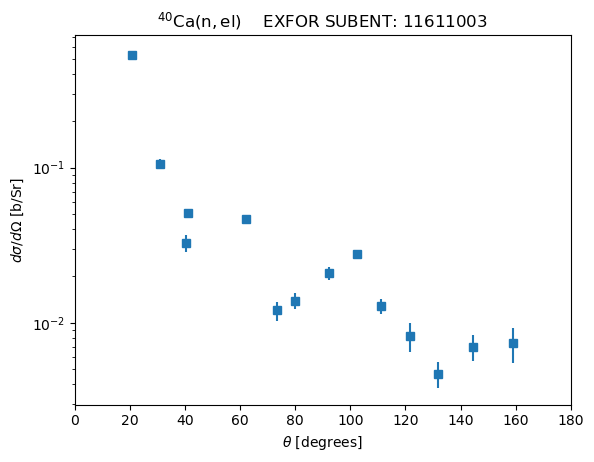

In [12]:
plt.errorbar(m.x, m.y, m.statistical_err, linestyle="none", marker="s")
plt.yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ " + f"[{m.x_units}]")
plt.ylabel(r"$d \sigma / d \Omega$ " + f"[{m.y_units}]")
plt.title(f"${rxn.reaction_latex}$\t EXFOR SUBENT: {m.subentry}")

# Now let's do a calibration

## Specify prior

In [13]:
alpha_0 = np.hstack((alpha_central, alpha_so))
alpha_std = 0.2 * alpha_0
prior = stats.multivariate_normal(mean=alpha_0, cov=np.diag((alpha_std) ** 2))

## Specifying the Model

In [14]:
from rxmc.params import Parameter

In [15]:
params = [
    Parameter("Vv", unit="MeV"),
    Parameter("Wv", unit="MeV"),
    Parameter("Rv", unit="fm"),
    Parameter("av", unit="fm"),
    Parameter("Wd", unit="MeV"),
    Parameter("Rd", unit="fm"),
    Parameter("ad", unit="fm"),
    Parameter("Vso", unit="MeV"),
    Parameter("Wso", unit="MeV"),
    Parameter("Rso", unit="fm"),
    Parameter("aso", unit="fm"),
]
len(params)

11

In [16]:
def extract_params(ws, *x):
    Vv, Wv, Rv, av, Wd, Rd, ad, Vso, Wso, Rso, aso = x
    central_params = (Vv, Wv, Rv, av, Wd, Rd, ad)
    spin_orbit_params = (Vso, Wso, Rso, aso)
    return central_params, spin_orbit_params

In [17]:
omp = rxmc.elastic_diffxs_model.ElasticDifferentialXSModel(
    "dXS/dA",
    interaction_central=central_potential,
    interaction_spin_orbit=spin_orbit_potential,
    calculate_interaction_from_params=extract_params,
    params=params,
    model_name="KD_recalibration_Ca40nn",
)

## Set up `Observation`

In [18]:
obs = rxmc.elastic_diffxs_observation.ElasticDifferentialXSObservation(
    measurement=m,
    reaction=rxn,
    quantity="dXS/dA",
    lmax=40,
)

## Test out default values
They should do a good job to describe our observation already. We will use them as a prior mean, so if they describe our data well, that means we will start in a high-likelihood region and converge quickly.

In [19]:
yth = omp.visualizable_model_prediction(obs, *alpha_0)

Text(0.5, 1.0, '$^{40} \\rm{Ca}(n,el)$\t EXFOR SUBENT: 11611003')

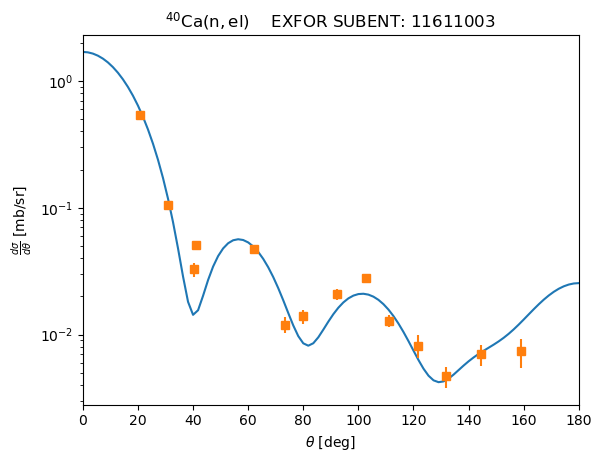

In [20]:
plt.plot(obs.angles_vis, yth)
plt.errorbar(m.x, m.y, m.statistical_err, linestyle="none", marker="s")
plt.yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$\frac{d \sigma}{d \theta}$ [mb/sr]")
plt.title(f"${rxn.reaction_latex}$\t EXFOR SUBENT: {m.subentry}")

## Specify Likelihood Model and Evidence

We will set `fractional_uncorrelated_error` as a fraction of the model prediction whose square will be added to the diagonal elements of the covariance while calculating the likelihood. This is often interpreted as a "model error", or "unaccounted-for-error". A better strategy would be to fit this value (e.g. using `rxmc.likelihood_model.UnknownNoiseFractionErrorModel`).

In [23]:
likelihood = rxmc.likelihood_model.LikelihoodModel(frac_err=0.1)

In [24]:
evidence = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs],
            omp,
            likelihood,
        )
    ]
)

## Specify sampling configuration

In [25]:
def proposal_distribution_model(x, rng):
    return stats.multivariate_normal.rvs(mean=x, cov=prior.cov / 100, random_state=rng)

In [26]:
sampling_conf = rxmc.param_sampling.MetropolisHastingsSampler(
    params=omp.params,
    starting_location=prior.mean,
    proposal=proposal_distribution_model,
    prior=prior,
)

TypeError: SamplingConfig.__init__() got an unexpected keyword argument 'proposal'

## Build Walker

In [ ]:
rng = np.random.default_rng(42)

In [ ]:
walker = rxmc.walker.Walker(
    model_sample_conf=sampling_conf,
    evidence=evidence,
    rng=rng,
)

## Run Calibration

In [ ]:
%%time
walker.walk(n_steps=200000)

## Write walker to disk

In [ ]:
with lzma.open("walker_ca40nn_kd_refit_100ksa.pkl.xz", "wb") as f:
    pickle.dump(walker, f)

## Visualize results

In [ ]:
def plot_chains(walker, model, true_params):
    fig, axes = plt.subplots(
        walker.model_chain.shape[1] + 1, 1, figsize=(8, 12), sharex=True
    )
    for i in range(walker.model_chain.shape[1]):
        axes[i].plot(walker.model_chain[:, i])
        axes[i].set_ylabel(f"${model.params[i].latex_name}$ [{model.params[i].unit}]")
        true_value = true_params[model.params[i].name]
        axes[i].hlines(true_value, 0, len(walker.model_chain), "r", linestyle="--")

    axes[-1].plot(walker.log_posterior_record)
    axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")
    axes[-1].set_xlabel(r"$i$")

In [ ]:
def plot_posterior_corner(walker, model, true_params, num_samples=10000):
    nsteps, npar = walker.model_chain.shape
    chain = walker.model_chain[np.random.choice(np.arange(nsteps), num_samples), :]
    fig = corner.corner(
        chain,
        labels=[p.name for p in model.params],
        label="posterior",
        truths=[true_params[p.name] for p in model.params],
    )
    fig.suptitle("posterior")

In [ ]:
plot_chains(walker, omp, dict([(p.name, x) for p, x in zip(params, alpha_0)]))

In [ ]:
plot_posterior_corner(walker, omp, dict([(p.name, x) for p, x in zip(params, alpha_0)]))

In [ ]:
n_steps, _ = walker.model_chain.shape

In [ ]:
num_samples = 1000
samples = walker.model_chain[np.random.choice(np.arange(n_steps), num_samples), :]

In [ ]:
y_pred_post = np.zeros((num_samples, len(obs.angles_vis)))

In [ ]:
for i in tqdm(range(num_samples)):
    y_pred_post[i, :] = omp.visualizable_model_prediction(obs, *samples[i, :])

In [ ]:
lower, med, upper = np.percentile(y_pred_post, [5, 50, 95], axis=0)

In [ ]:
plt.plot(
    obs.angles_vis,
    med,
    ":",
)
plt.fill_between(
    obs.angles_vis, lower, upper, alpha=0.3, label="recal, inner 90th pctl"
)
plt.errorbar(
    m.x,
    m.y,
    m.statistical_err,
    linestyle="none",
    marker="s",
    label="McDonald & Robson, 1964",
)
plt.plot(obs.angles_vis, omp.visualizable_model_prediction(obs, *alpha_0), label="KD")

plt.yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$\frac{d \sigma}{d \theta}$ [mb/sr]")
plt.legend()
plt.title(f"${rxn.reaction_latex}$\t EXFOR SUBENT: {m.subentry}")